# **IMPORT LIBS**

In [130]:
import keras
import pandas as pd
import numpy as np
import warnings
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
#from skimage.transform import rotate, shear, zoom
#from imgaug import augmenters as iaa
import tensorflow as tf
import math

import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

warnings.filterwarnings('ignore')

#**LOAD THE MODEL**

In [131]:
model = tf.keras.models.load_model('./model_v40.h5')

# (Optional) Print a summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1, 128)            1664      
                                                                 
 dense_1 (Dense)             (None, 1, 64)             8256      
                                                                 
 dense_2 (Dense)             (None, 1, 32)             2080      
                                                                 
 dense_3 (Dense)             (None, 1, 16)             528       
                                                                 
 dense_4 (Dense)             (None, 1, 12)             204       
                                                                 
Total params: 12732 (49.73 KB)
Trainable params: 12732 (49.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# **AUX FUNCTIONS**

In [132]:
def save_manovers_positions_to_csv_file(gps_positions, manovers, filename):
  output = np.zeros_like(gps_positions)

  # Iterate through the elements of arr2
  for i in range(len(manovers)):
    # Check if the element in arr2 is 1
    if manovers[i] == 1:
      # Copy the corresponding values from arr1 to the output array
      output[i] = gps_positions[i]

  output = output[~np.all(output == 0, axis=1)]
  np.savetxt(filename, output, delimiter=',', fmt='%.9f')



def separate_positives_negatives(data):
  # Ensure the input is converted to a NumPy array for easier manipulation
  data = np.array(data)

  # Create two empty arrays to store positive and negative values
  positives = np.zeros_like(data)
  negatives = np.zeros_like(data)

  # Use boolean indexing to separate positive and negative values
  positives[data > 0] = data[data > 0]
  negatives[data < 0] = -data[data < 0]

  # Combine the positive and negative values into a single 2D array
  return (positives, negatives)

def normalize_between_0_and_max(data):
  max_value = np.max(data)
  return data / max_value

def normalize_between_0_and_max_v2(data, max_value):
  return data / max_value

def split_train_test(data, test_size=0.2):
  # Check if test_size is between 0 and 1
  if test_size < 0 or test_size > 1:
    raise ValueError("test_size must be between 0 and 1.")

  # Get the number of samples
  num_samples = data.shape[0]

  # Calculate the number of samples for each set
  train_size = int(num_samples * (1 - test_size))
  test_size = num_samples - train_size

  # Randomly shuffle the data for better splitting (optional)
  #np.random.shuffle(data)

  # Split the data into training and test sets
  train_data = data[:train_size]
  test_data = data[train_size:]

  return train_data, test_data

def y_classification(data, threshold):
  classification = np.zeros_like(data, dtype=int)  # Initialize output array

  for col in range(0, 12):  # Loop through each column
    max_value = np.max(data[:, col])
    threshold_pos = max_value * threshold
    classification[:, col] = np.where(data[:, col] >= threshold_pos, 1, 0)

  return classification

def max_of_vectors(vec1, vec2, vec3, vec4, vec5, vec6):
  # Combine all vectors into a single array
  all_vectors = np.array([vec1, vec2, vec3, vec4, vec5, vec6])

  # Find the maximum value in the array
  max_value = np.max(all_vectors)

  return max_value

def random_aug_op(data, columnName):
  random_number = np.random.rand()

  if random_number < 0.5:
    #data = data - data*0.05
    data = data - data*random_number
  else:
    #data = data + data*0.05
    data = data + data*(1-random_number)

  return data
  #newrow = pd.DataFrame({columnName: [data]})
  #newrow = pd.DataFrame([data])
  #return newrow

def tabular_dataaugmentation(data):
  augmented_data = data.copy()
  augmented_data_list = augmented_data.to_numpy()
  print(augmented_data_list)

  for i in data:
    for j in range(10):
      #augmented_data = pd.concat([augmented_data, random_aug_op(i, data.name)])
      #augmented_data_list.append(random_aug_op(i, data.name))
      augmented_data_list = np.append(augmented_data_list, random_aug_op(i, data.name))

  #return augmented_data
  #return pd.DataFrame(augmented_data_list).drop(0).reset_index(drop=True)
  dataframe = pd.DataFrame(augmented_data_list)
  finaldataframe = dataframe[0]
  return finaldataframe

# **IMPORT DATA**

In [133]:
#df = pd.read_csv('Dataset-viagens-longas.csv')
df = pd.read_csv('Abrantes-Leiria.csv')

acelX = df['accelerometerXAxis']
acelY = df['accelerometerYAxis']
acelZ = df['accelerometerZAxis']

gyrX = df['gyroscopeXAxis']
gyrY = df['gyroscopeYAxis']
gyrZ = df['gyroscopeZAxis']

latitude = df['latitude']
longitude = df['longitude']

In [134]:
print(df['accelerometerXAxis'].describe())
print(df['accelerometerYAxis'].describe())
print(df['accelerometerZAxis'].describe())
print(df['gyroscopeXAxis'].describe())
print(df['gyroscopeYAxis'].describe())
print(df['gyroscopeZAxis'].describe())

count    35129.000000
mean         0.066414
std          1.245461
min         -8.641076
25%         -0.579987
50%          0.052194
75%          0.699165
max          8.997051
Name: accelerometerXAxis, dtype: float64
count    35129.000000
mean         0.151044
std          0.990845
min         -9.755715
25%         -0.420916
50%          0.152290
75%          0.720796
max          7.688001
Name: accelerometerYAxis, dtype: float64
count    35129.000000
mean         0.014258
std          1.411844
min        -14.865593
25%         -0.860741
50%          0.028166
75%          0.886975
max         12.408630
Name: accelerometerZAxis, dtype: float64
count    35129.000000
mean        -0.000223
std          0.106395
min         -0.748310
25%         -0.062919
50%         -0.000611
75%          0.061087
max          0.883922
Name: gyroscopeXAxis, dtype: float64
count    35129.000000
mean         0.003045
std          0.165580
min         -1.225396
25%         -0.087354
50%          0.001222
75% 

# **DATA AUGEMTATION**

In [135]:
acelXaug = tabular_dataaugmentation(acelX)
print(acelX.shape)
print(acelXaug.shape)
acelYaug = tabular_dataaugmentation(acelY)
acelZaug = tabular_dataaugmentation(acelZ)
gyrXaug = tabular_dataaugmentation(gyrX)
gyrYaug = tabular_dataaugmentation(gyrY)
gyrZaug = tabular_dataaugmentation(gyrZ)

latitudeaug = tabular_dataaugmentation(latitude)
longitudeaug = tabular_dataaugmentation(longitude)

[ 0.89889485  0.04369587 -0.77212536 ... -0.23127282  0.49910891
  0.04740443]
(35129,)
(386419,)
[ 0.6757679  -0.25811958  0.11312008 ...  0.09527779  0.33224583
  0.04727745]
[ 0.34061792  0.15225522 -0.45630079 ... -0.34803924 -0.32808512
 -0.03482494]
[ 0.09529498  0.02932153  0.06597345 ... -0.03420845  0.00671952
 -0.05009095]
[-0.09712757 -0.0720821   0.03359759 ... -0.05009095  0.01160644
  0.05558874]
[ 0.00549779 -0.02138028 -0.00855211 ... -0.00244346 -0.02076942
 -0.01282817]
[39.45946884 39.45946884 39.45946884 ... 39.73841095 39.73841095
 39.73841095]
[-8.19890499 -8.19890499 -8.19890499 ... -8.80177879 -8.80177879
 -8.80177879]


In [136]:

acelXaug = tabular_dataaugmentation(acelX)
print("data aug end")
print(acelXaug)
print(acelX)

[ 0.89889485  0.04369587 -0.77212536 ... -0.23127282  0.49910891
  0.04740443]
data aug end
0         0.898895
1         0.043696
2        -0.772125
3         0.267107
4         0.369875
            ...   
386414    0.036258
386415    0.042239
386416    0.032968
386417    0.035483
386418    0.029808
Name: 0, Length: 386419, dtype: float64
0        0.898895
1        0.043696
2       -0.772125
3        0.267107
4        0.369875
           ...   
35124    0.089524
35125    0.296395
35126   -0.231273
35127    0.499109
35128    0.047404
Name: accelerometerXAxis, Length: 35129, dtype: float64


# **SEPARATE DATA BY MANOVER**

In [137]:
#turnRightX, turnLeftX = separate_positives_negatives(acelX)
turnRightX, turnLeftX = separate_positives_negatives(acelXaug)

#accelY, breakY = separate_positives_negatives(acelY)
accelY, breakY = separate_positives_negatives(acelYaug)

#positiveZ, negativeZ = separate_positives_negatives(acelZ)
positiveZ, negativeZ = separate_positives_negatives(acelZaug)

#gyrPositiveX, gyrNegativeX = separate_positives_negatives(gyrX)
gyrPositiveX, gyrNegativeX = separate_positives_negatives(gyrXaug)

#gyrPositiveY, gyrNegativeY = separate_positives_negatives(gyrY)
gyrPositiveY, gyrNegativeY = separate_positives_negatives(gyrYaug)

#gyrPositiveZ, gyrNegativeZ = separate_positives_negatives(gyrZ)
gyrPositiveZ, gyrNegativeZ = separate_positives_negatives(gyrZaug)

In [138]:
turnRightX.shape

(386419,)

# **CLASSIFICATION BASED ON NOT NORMALIZED VALUES**

In [139]:
newArray1 = np.array(list(zip(turnRightX, turnLeftX, accelY, breakY, positiveZ, negativeZ, gyrPositiveX, gyrNegativeX, gyrPositiveY, gyrNegativeY, gyrPositiveZ, gyrNegativeZ)))

y = y_classification(newArray1, 0.3)
print (np.sum(y, axis=0))
np.savetxt("Y.csv", y, delimiter=',', fmt='%.0i')

[3669 4087 2232  619 1104  339 2124 2301 2440 3418 5050 1301]


# **NORMALIZE DATA**

In [140]:
max_accel = max_of_vectors(turnRightX, turnLeftX, accelY, breakY, positiveZ, negativeZ)
max_gyr = max_of_vectors(gyrPositiveX, gyrNegativeX, gyrPositiveY, gyrNegativeY, gyrPositiveZ, gyrNegativeZ)

In [141]:
turnRightXn = normalize_between_0_and_max_v2(turnRightX, max_accel)
turnLeftXn = normalize_between_0_and_max_v2(turnLeftX, max_accel)
accelYn = normalize_between_0_and_max_v2(accelY, max_accel)
breakYn = normalize_between_0_and_max_v2(breakY, max_accel)
positiveZn = normalize_between_0_and_max_v2(positiveZ, max_accel)
negativeZn = normalize_between_0_and_max_v2(negativeZ, max_accel)
gyrPositiveXn = normalize_between_0_and_max_v2(gyrPositiveX, max_gyr)
gyrNegativeXn = normalize_between_0_and_max_v2(gyrNegativeX, max_gyr)
gyrPositiveYn = normalize_between_0_and_max_v2(gyrPositiveY, max_gyr)
gyrNegativeYn = normalize_between_0_and_max_v2(gyrNegativeY, max_gyr)
gyrPositiveZn = normalize_between_0_and_max_v2(gyrPositiveZ, max_gyr)
gyrNegativeZn = normalize_between_0_and_max_v2(gyrNegativeZ, max_gyr)

# **CREATE AN ARRAY WITH ALL DATA**

In [142]:
newArray = np.array(list(zip(turnRightXn, turnLeftXn, accelYn, breakYn, positiveZn, negativeZn, gyrPositiveXn, gyrNegativeXn, gyrPositiveYn, gyrNegativeYn, gyrPositiveZn, gyrNegativeZn)))

In [143]:
newArray.shape

(386419, 12)

In [11]:
#y1 = y_classification(newArray, 0.3)
#print (np.sum(y1, axis=0))
#np.savetxt("Y.csv", y1, delimiter=',', fmt='%.0i')

# **SHOW MANOVERS ON GOOLGE MAP**

In [144]:
positions = np.array(list(zip(latitude, longitude)))
manover_accelY = y[:, 2]
print(manover_accelY)
manover_breakY = y[:, 3]
manover_turnRightXn = y[:, 0]
manover_turnLeftXn = y[:, 1]
gyrPositiveZn = y[:, 10]
gyrNegativeZn = y[:, 11]
save_manovers_positions_to_csv_file(positions, manover_accelY, "accelY.csv")
save_manovers_positions_to_csv_file(positions, manover_breakY, "breakY.csv")
save_manovers_positions_to_csv_file(positions, manover_turnRightXn, "turnRightX.csv")
save_manovers_positions_to_csv_file(positions, manover_turnLeftXn, "turnLeftX.csv")
save_manovers_positions_to_csv_file(positions, gyrPositiveZn, "gyrPositZ.csv")
save_manovers_positions_to_csv_file(positions, gyrNegativeZn, "gyrNegZ.csv")

[0 0 0 ... 0 0 0]


IndexError: index 37679 is out of bounds for axis 0 with size 35129

# **PLOT MANOVERS**

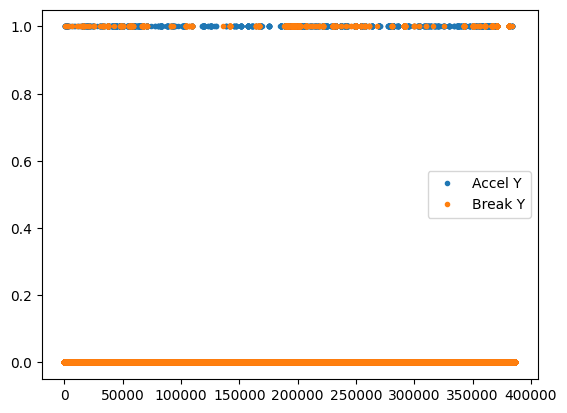

In [145]:
plt.plot(y[:, 2], marker='.', linestyle='none')
plt.plot(y[:, 3], marker='.', linestyle='none')

plt.legend(['Accel Y', 'Break Y'])
plt.show()

# **SEPARATE DATA IN TRAIN AND TEST**

In [146]:
np.savetxt("TESTECSV1_NORMAL.csv", newArray, delimiter=',', fmt='%.0i')
np.savetxt("TESTECSV1_CLASSIFICADOS.csv", y, delimiter=',', fmt='%.0i')


x_treino, x_teste = split_train_test(newArray, test_size=0.2)


y_treino, y_teste = split_train_test(y, test_size=0.2)



# **CREATE THE INPUT TENSORES DATA**

In [148]:
treino = x_treino.reshape(x_treino.shape[0], 1, x_treino.shape[1])
teste = x_teste.reshape(x_teste.shape[0], 1, x_teste.shape[1])

In [149]:
print(y_treino.shape[1])

12


# **CREATE THE MODEL**

In [150]:
K.clear_session()

model = Sequential()
model.add(Dense(128, input_shape=(1, treino.shape[2]), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='linear'))
model.add(Dropout(0.5))
model.add(Dense(y_treino.shape[1], activation='sigmoid'))

# **COMPILE THE MODEL**

In [151]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)

# **TRAIN THE MODEL**

In [152]:
#model_output = model.fit(treino, y_treino, epochs=10, batch_size=4, verbose=1, shuffle=False, callbacks=[early_stop], validation_data=(teste, y_teste))
model_output = model.fit(treino, y_treino, epochs=10, batch_size=4, verbose=1, shuffle=False, callbacks=[early_stop], validation_data=(teste, y_teste))

Epoch 1/10
77284/77284 [==============================] - 58s 752us/step - loss: 0.0062 - accuracy: 0.8032 - val_loss: 0.0073 - val_accuracy: 0.9927
Epoch 2/10
77284/77284 [==============================] - 59s 769us/step - loss: 0.0059 - accuracy: 0.9800 - val_loss: 0.0073 - val_accuracy: 0.9927
Epoch 3/10
77284/77284 [==============================] - 60s 775us/step - loss: 0.0059 - accuracy: 0.9840 - val_loss: 0.0073 - val_accuracy: 0.9927
Epoch 4/10
77284/77284 [==============================] - 60s 778us/step - loss: 0.0059 - accuracy: 0.9883 - val_loss: 0.0073 - val_accuracy: 0.9927
Epoch 5/10
77284/77284 [==============================] - 60s 779us/step - loss: 0.0059 - accuracy: 0.9904 - val_loss: 0.0073 - val_accuracy: 0.9927
Epoch 6/10
77284/77284 [==============================] - 60s 782us/step - loss: 0.0059 - accuracy: 0.9907 - val_loss: 0.0073 - val_accuracy: 0.9927
Epoch 7/10
77284/77284 [==============================] - 61s 783us/step - loss: 0.0059 - accuracy: 0.9911

# **SHOW THE RESULTS**

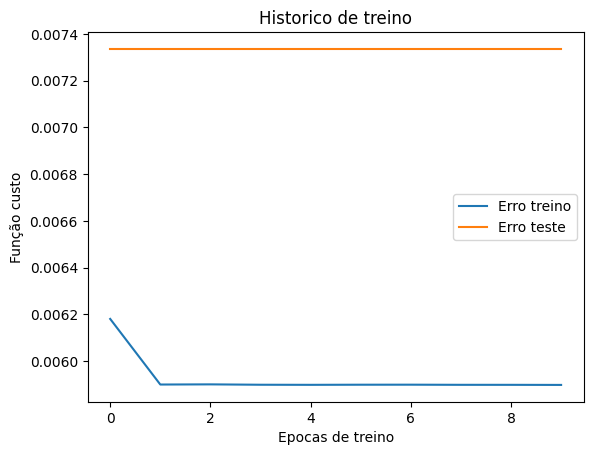

In [153]:
plt.plot(model_output.history['loss'])
plt.plot(model_output.history['val_loss'])
plt.title('Historico de treino')
plt.xlabel('Epocas de treino')
plt.ylabel('Função custo')
plt.legend(['Erro treino', 'Erro teste'])
plt.show()

In [ ]:
#accuracy = model_lstm.evaluate(teste, y_teste)[1]  # Assuming accuracy is the second metric
#print('Test Accuracy:', accuracy)

# **TEST THE NETWORK**

In [154]:
loss = model.evaluate(teste, y_teste, batch_size=1)
print('Test loss:', loss)


77284/77284 [==============================] - 34s 433us/step - loss: 0.0073 - accuracy: 0.9927
Test loss: [0.0073355743661522865, 0.9926645159721375]


In [155]:
teste[0]

array([[0.        , 0.12590456, 0.        , 0.01743454, 0.        ,
        0.0349228 , 0.08106817, 0.        , 0.        , 0.07270571,
        0.03279215, 0.        ]])

In [156]:
teste.shape

(77284, 1, 12)

In [157]:
i = 0
for i in range(100):
    a = x_teste[i]
    b = a.reshape(1, 1, 12)

    # Make predictions on new data
    prediction = model.predict(b)
    #predicted_class = label_encoder.inverse_transform(prediction)[0]

    np.round(prediction, decimals=1, out=prediction)
    np.round(x_teste[i], decimals=1, out=x_teste[i])
    #print("Value:", newArray[i + start])
    if (np.sum(y_teste[i]) > 0):
      print("X [:", x_teste[i])
      print("Y [:", y_teste[i])
      print("PC:", prediction)
      print (i)
    i = 1 + 1
#PREDICTIONS WITH COLAB MODEL
#prediction = model.predict(teste)
#print("Predicted class:", prediction)
#print("Predicted class:", predicted_class)

1/1 [==============================] - 0s 9ms/step
X [: [0.2 0.  0.  0.  0.2 0.  0.1 0.  0.  0.  0.  0. ]
Y [: [1 0 0 0 0 0 0 0 0 0 0 0]
PC: [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]
35
1/1 [==============================] - 0s 7ms/step
X [: [0.2 0.  0.  0.  0.1 0.  0.1 0.  0.1 0.  0.  0. ]
Y [: [1 0 0 0 0 0 0 0 0 0 0 0]
PC: [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]
38
1/1 [==============================] - 0s 7ms/step
X [: [0.2 0.  0.  0.  0.2 0.  0.  0.  0.  0.  0.  0. ]
Y [: [1 0 0 0 0 0 0 0 0 0 0 0]
PC: [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]
39
1/1 [==============================] - 0s 7ms/step
X [: [0.  0.2 0.  0.  0.  0.  0.1 0.  0.  0.1 0.  0. ]
Y [: [0 1 0 0 0 0 0 0 0 0 0 0]
PC: [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]
44
1/1 [==============================] - 0s 8ms/step
X [: [0.  0.2 0.  0.  0.  0.  0.1 0.  0.  0.1 0.  0. ]
Y [: [0 1 0 0 0 0 0 0 0 0 0 0]
PC: [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]
46
1/1 [==============================] - 0s 8ms/step


In [158]:
teste_value = np.array([0., 0.363, 0.313, 0., 0., 0.31, 0.393, 0., 0., 0.244, 0.247, 0.])
teste_value = teste_value.reshape(1, 1, 12)

# Make predictions on new data
prediction = model.predict(teste_value)
np.round(prediction, decimals=2, out=prediction)

print("Value    :", teste_value[0][0])
print("Predicted:", prediction[0])


1/1 [==============================] - 0s 9ms/step
Value    : [0.    0.363 0.313 0.    0.    0.31  0.393 0.    0.    0.244 0.247 0.   ]
Predicted: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


# **SAVE THE MODEL**

In [26]:
import os
model.save(os.path.join(".", 'model_v40.h5'))

dataaug = 5%

como melhorar uma rede mlp para problemas multiclasse em que cada amostra pode cair em mais que uma classe


matriz de confusao 